In [8]:
import tensorflow as tf

# Limit GPU memory allocation to 20%
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to allocate only 20% of the GPU memory
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 4)])  # 4 GB limit
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import ResNet152V2
from keras.applications.vgg16 import VGG16
import numpy as np
from glob import glob

In [11]:
# Set up data generators for training and validation
IMAGE_SIZE = [224, 224]
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Rescale pixel values to [0, 1]
    shear_range=0.2,  # Apply shear transformations
    zoom_range=0.2,   # Apply zoom transformations
    horizontal_flip=True  # Flip images horizontally
)

test_datagen = ImageDataGenerator(rescale=1.0/255)  # Only rescale for validation/test data

# Flow training images in batches using the data generators
train_set = train_datagen.flow_from_directory('/content/drive/MyDrive/DataSet/train', target_size=IMAGE_SIZE, batch_size=32, class_mode='categorical')

# Flow validation images in batches
valid_set = test_datagen.flow_from_directory('/content/drive/MyDrive/DataSet/val', target_size=IMAGE_SIZE, batch_size=32, class_mode='categorical')


Found 2005 images belonging to 4 classes.
Found 324 images belonging to 4 classes.


In [20]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load the VGG16 model with ImageNet weights and add a preprocessing layer
vgg16_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Add a preprocessing layer to normalize input
preprocessed_input = preprocess_input(vgg16_model.input)


In [21]:
# Don't train existing weights in the ResNet-152V2 model
for layer in resnet152V2.layers:
    layer.trainable = False

In [22]:
from glob import glob

# List all subdirectories in the training dataset directory
folders = glob('/content/drive/MyDrive/DataSet/train/*')

# Get the number of output classes
num_classes = len(folders)

In [23]:
from tensorflow.keras.layers import Flatten

# Add a Flatten layer to the output of the ResNet-152V2 model
x = Flatten()(resnet152V2.output)

In [24]:
print(x)

KerasTensor(type_spec=TensorSpec(shape=(None, 25088), dtype=tf.float32, name=None), name='flatten_1/Reshape:0', description="created by layer 'flatten_1'")


In [25]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

# Define the number of output classes (should be equal to the number of folders)
num_classes = len(folders)
# Create a Dense layer for classification with the number of units equal to the number of output classes
prediction = Dense(num_classes, activation='softmax')(x)

# Create a model object with ResNet-152V2 as the base model and the Dense layer for classification
model = Model(inputs=resnet152V2.input, outputs=prediction)

In [26]:
# Display the model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [27]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [28]:
# Use the Image Data Generator to import the images from the dataset
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [29]:
# Set up a data generator for the training dataset
training_set = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/DataSet/train',
    target_size=(224, 224),  # Ensure the same target size as initialized
    batch_size=32,
    class_mode='categorical'
)

Found 2005 images belonging to 4 classes.


In [30]:
# Set up a data generator for the test dataset
test_set = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/DataSet/test',
    target_size=(224, 224),  # Ensure the same target size as initialized
    batch_size=32,
    class_mode='categorical'
)

Found 18 images belonging to 4 classes.


In [31]:
  # fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-31-d2f7b4b23126>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/20
63/63 [==============================] - 509s 8s/step - loss: 0.6341 - accuracy: 0.7726 - val_loss: 0.2851 - val_accuracy: 0.8889
Epoch 2/20
63/63 [==============================] - 35s 556ms/step - loss: 0.2413 - accuracy: 0.9112 - val_loss: 0.2052 - val_accuracy: 0.8889
Epoch 3/20
63/63 [==============================] - 35s 560ms/step - loss: 0.1741 - accuracy: 0.9367 - val_loss: 0.1819 - val_accuracy: 0.8889
Epoch 4/20
63/63 [==============================] - 34s 533ms/step - loss: 0.1285 - accuracy: 0.9546 - val_loss: 0.1091 - val_accuracy: 0.9444
Epoch 5/20
63/63 [==============================] - 34s 534ms/step - loss: 0.1119 - accuracy: 0.9606 - val_loss: 0.1255 - val_accuracy: 0.9444
Epoch 6/20
63/63 [==============================] - 35s 548ms/step - loss: 0.1169 - accuracy: 0.9566 - val_loss: 0.2608 - val_accuracy: 0.9444
Epoch 7/20
63/63 [==============================] - 35s 552ms/step - loss: 0.0945 - accuracy: 0.9661 - val_loss: 0.0485 - val_accuracy: 1.0000
E

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve, average_precision_score, auc

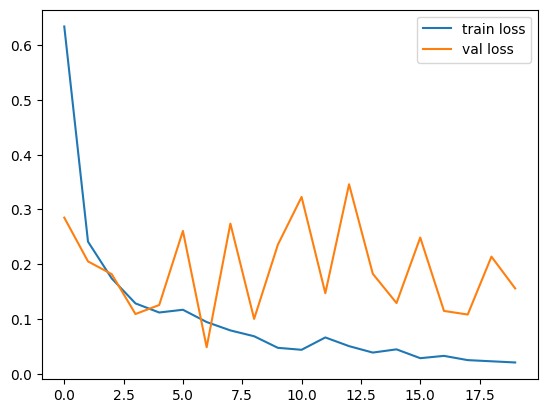

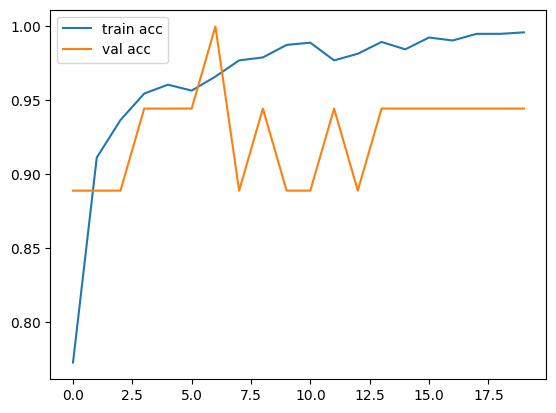

<Figure size 640x480 with 0 Axes>

In [33]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

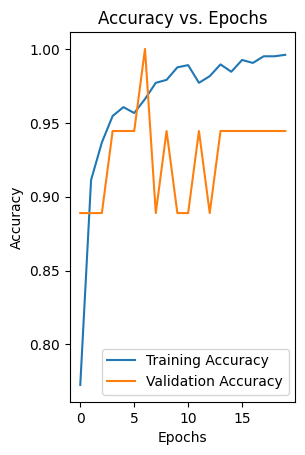

In [34]:
plt.subplot(1, 2, 2)
plt.plot(r.history['accuracy'], label='Training Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

In [ ]:
model=load_model('/content/drive/MyDrive/DataSet/my_model.h5')